# Solution

In [1]:
import cv2
import time
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
img_path = './data/2.jpeg'
radius_range = range(3, 20, 4)

## OpenCV

In [3]:
def cv_median_filter(img_path, r):
    img = cv2.imread(img_path)
    return cv2.medianBlur(img, r)

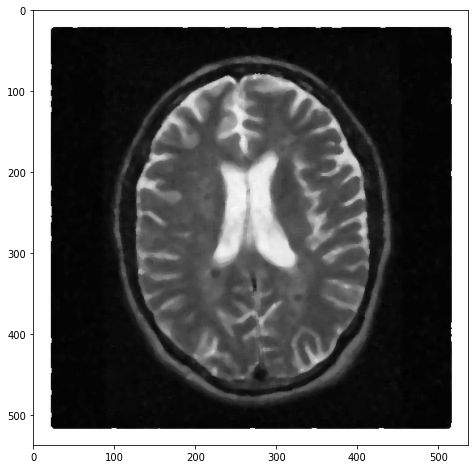

In [4]:
filtered_img = cv_median_filter('./data/2.jpeg', 2 * 3 + 1)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(filtered_img, cv2.COLOR_BGR2RGB))
plt.show()

## My implementations

### Simple sorting

In [5]:
def simple_median_filter(img_path, r, threshold=0.):
    img = Image.open(img_path)
    img_arr = np.array(img)
    
    h, w, c = img_arr.shape
    img_arr = np.pad(img_arr, [(r, r), (r, r), (0, 0)], 'symmetric')
    filtered_img = np.zeros((h, w, c), dtype=int)

    for h_i in range(r, h + r):
        for w_i in range(r, w + r):
            
            window = img_arr[h_i - r : h_i + r + 1, w_i - r : w_i + r + 1]
            flattened_window = window.reshape(np.product((2 * r + 1) * (2 * r + 1)), -1)
            
            r_median = np.median(flattened_window[:, 0])
            g_median = np.median(flattened_window[:, 1])
            b_median = np.median(flattened_window[:, 2])
            
            median = [r_median, g_median, b_median]
            
            max_diff = max(sum(abs(median -  np.array([0, 0, 0]))), sum(abs(median -  np.array([256, 256, 256]))))
            if sum(abs(filtered_img[h_i - r, w_i - r] - median)) > threshold * max_diff:
                filtered_img[h_i - r, w_i - r] = median            
            
    return filtered_img

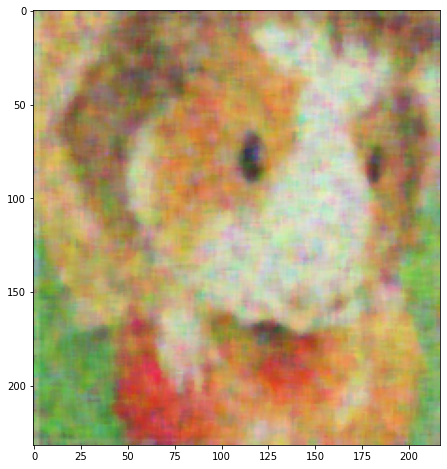

In [6]:
# works for color image
filtered_img = simple_median_filter('./data/1.jpeg', 3, 0.1)

plt.figure(figsize=(10, 8))
plt.imshow(filtered_img)
plt.show()

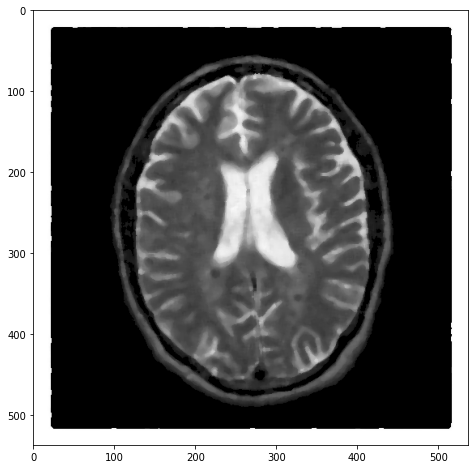

In [7]:
filtered_img = simple_median_filter('./data/2.jpeg', 3, 0.1)

plt.figure(figsize=(10, 8))
plt.imshow(filtered_img)
plt.show()

### Huang's O(n) (ONLY FOR GRAYSCALE IMAGES)

In [8]:
def huang_median_filter(img_path, r, threshold=0):
    img = Image.open(img_path)
    img_arr= np.array(img.convert('L'))
    
    h, w = img_arr.shape
    img_arr = np.pad(img_arr, r, 'symmetric')
    filtered_img = np.zeros((h, w), dtype=int) 
    
    for h_i in range(h):
        
        init_window = img_arr[h_i : h_i + 2 * r + 1, 0 : 2 * r + 1]
        
        color_values = init_window.flatten()
        hist = np.histogram(color_values, np.arange(257))[0]
        med = int(np.median(color_values))
        lt_med = len(list(filter(lambda x: x < med, color_values))) 
        
        filtered_img[h_i, 0] = med
        
        for w_i in range(1, w):
            for k in range(2 * r + 1):
                
                prev_el = img_arr[h_i + k, w_i - 1] 
                next_el = img_arr[h_i + k, w_i + 2 * r] 
                
                hist[prev_el] -= 1
                lt_med -= 1 if prev_el < med else 0
                hist[next_el] += 1
                lt_med += 1 if next_el < med else 0

                if lt_med > threshold:
                    while lt_med > threshold:
                        med -= 1
                        lt_med -= hist[med]
                else: 
                    while lt_med + hist[med] <= threshold:
                        lt_med += hist[med]
                        med += 1       
                            
            filtered_img[h_i, w_i] = med
            
    return filtered_img

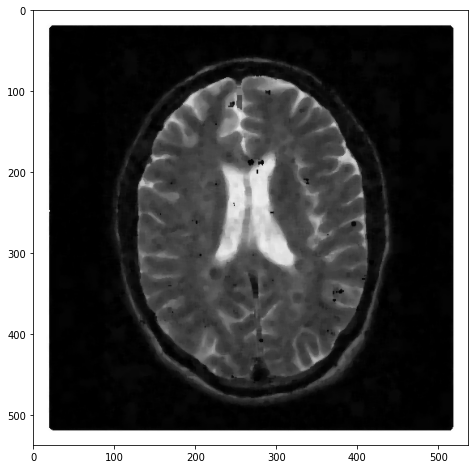

In [9]:
filtered_img = huang_median_filter('./data/2.jpeg', 3, 9)

plt.figure(figsize=(10, 8))
plt.imshow(filtered_img, cmap = 'gray')
plt.show()

### Fastest (ONLY FOR GRAYSCALE IMAGES)

In [10]:
def fastest_median_filter(img_path, r, threshold=0):
    img = Image.open(img_path)
    img = img.convert('L')
    img_arr = np.array(img)

    h, w = img_arr.shape
    img_arr = np.pad(img_arr, r, 'symmetric')
    filtered_img = np.zeros((h, w), dtype=int) 
    
    init_window = img_arr[0 : 2 * r + 1, :]
    column_hists = np.zeros((w + 2 * r, 256), dtype=int)
    
    
    for h_i in range(h):
        if (0 == column_hists).all():
            for col in range(w + 2 * r):
                column_hists[col] = np.histogram(init_window[:, col], np.arange(257))[0]
        else:
            for col in range(w + 2 * r):
                column_hists[col] -= np.histogram(img_arr[h_i - 1, col], np.arange(257))[0]
                column_hists[col] += np.histogram(img_arr[h_i + 2 * r, col], np.arange(257))[0]
        
        hist = sum(column_hists[: 2 * r + 1]) 
        med = np.argsort(hist)[127]
        lt_med = sum(hist[: med])

        filtered_img[h_i, 0] = med
        
        for w_i in range(1, w):
            
            hist -= column_hists[w_i - 1]
            lt_med -= sum(column_hists[w_i - 1][: med])
            
            hist += column_hists[w_i + 2 * r]
            lt_med += sum(column_hists[w_i + 2 * r][: med]) 
            

            if lt_med > threshold:
                while lt_med > threshold:
                    med -= 1
                    lt_med -= hist[med]
            else: 
                while lt_med + hist[med] <= threshold:
                    lt_med += hist[med]
                    med += 1           
            
            filtered_img[h_i, w_i] = med
            
    return filtered_img

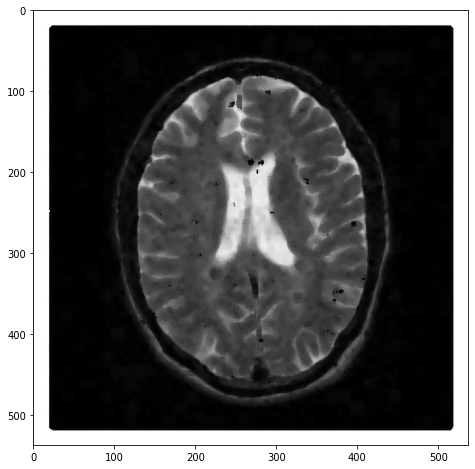

In [11]:
filtered_img = fastest_median_filter('./data/2.jpeg', 3, 9)

plt.figure(figsize=(10, 8))
plt.imshow(filtered_img, cmap = 'gray')
plt.show()

## Testing speed

In [12]:
def plot_radius_speed(img_path, time_vals, title='Simle'):
    img = Image.open(img_path)
    h, w, _ = np.array(img).shape

    speed = list(map(lambda t: t * 1e3 / (h * w / 1e6), time_vals))

    plt.plot(radius_range, speed)
    plt.title(title)
    plt.xlabel('Radius')
    plt.ylabel('Speed')
    plt.show()

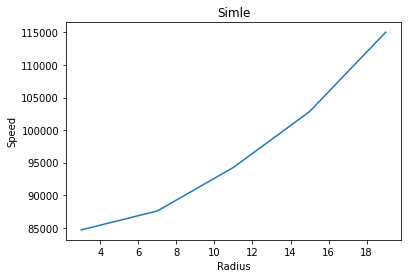

In [13]:
time_vals = []
for r in radius_range:
    start_time = time.time()
    filtered_img = simple_median_filter(img_path, r, 0.1)
    end_time = time.time()
    time_vals.append(end_time - start_time)
    
plot_radius_speed(img_path, time_vals)

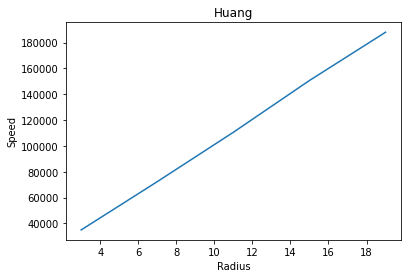

In [14]:
time_vals = []
for r in radius_range:
    start_time = time.time()
    filtered_img = huang_median_filter(img_path, r, r)
    end_time = time.time()
    time_vals.append(end_time - start_time)
    
plot_radius_speed(img_path, time_vals, title='Huang')

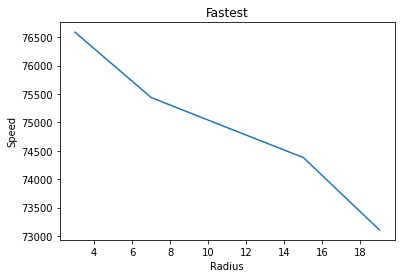

In [15]:
time_vals = []
for r in radius_range:
    start_time = time.time()
    filtered_img = fastest_median_filter(img_path, r, r)
    end_time = time.time()
    time_vals.append(end_time - start_time)
    
plot_radius_speed(img_path, time_vals, title='Fastest')